In [1]:
def off_diagonal_vec(sop):
    new_mat = []
    for i, row in enumerate(sop):
        for j, col in enumerate(row):
            if i==j:
                continue
            new_mat.append(col)
    return np.array(new_mat)

In [2]:
def sop_to_ptm(sop):
    ret = np.zeros((4,4))
    for i, p in enumerate(ps):
        for j, q in enumerate(ps):
            ret[i][j] = np.trace(p.dot(sop.dot(q.dot(np.conj(sop.T)))))
    return ret

In [3]:
import cvxpy as cp
from scipy.linalg import expm
import numpy as np
from pauli_channel_approximation import off_diagonal_projection

scales = [1.064, 1.039, .937, .912]
x = np.array([[0, 1], [1, 0]])
unitaries = []
ps = [np.eye(2), x, np.array([[0, -1.j], [1.j, 0]]), np.array([[1, 0], [0, -1]])]
pps = [np.kron(p, q) for p in ps for q in ps]
vecs = []
for scale in scales:
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    vecs.append(off_diagonal_vec(sop_to_ptm(error)))

/Users/anthonypolloreno/.pyenv/versions/3.6.3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [4]:
omega = cp.Variable(4)
constraints = [0 <= omega, omega <= 1, sum(omega) == 1]
objective_argument = cp.norm(np.matrix(np.vstack(vecs).T) * omega)
objective = cp.Minimize(objective_argument)
prob = cp.Problem(objective, constraints)
_ = prob.solve(verbose=True)
res = omega.value


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.000e+00  +2e+01  4e-01  1e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.866e-01  -3.890e-01  +2e+00  5e-02  1e-02  3e-01  3e-01  0.8738  1e-01   1  1  1 |  0  0
 2  -9.174e-03  -2.025e-02  +1e-01  2e-03  6e-04  1e-02  2e-02  0.9509  2e-03   2  2  2 |  0  0
 3  -1.002e-04  -2.223e-04  +1e-03  2e-05  6e-06  1e-04  2e-04  0.9890  1e-04   3  2  2 |  0  0
 4  -1.108e-06  -2.471e-06  +1e-05  3e-07  7e-08  1e-06  2e-06  0.9890  1e-04   5  3  3 |  0  0
 5  -1.226e-08  -2.747e-08  +2e-07  3e-09  7e-10  2e-08  2e-08  0.9890  1e-04   1  1  1 |  0  0
 6  -1.356e-10  -3.055e-10  +2e-09  3e-11  8e-12  2e-10  3e-10  0.9890  1e-04   2  0  0 |  0  0

OPTIMAL (within feastol=3.2e-11, reltol=1.3e+01, abstol=1.7e-09).
Runtime: 0.000490 seconds.



In [7]:
a = [[0.307 ],[0.283],[0.211],[0.199]]

In [8]:
sum([b[0] for b in a])

1.0

In [9]:
from pauli_channel_approximation import *

In [5]:
res

array([0.30644043, 0.28329703, 0.21172833, 0.19853421])

/Users/anthonypolloreno/.pyenv/versions/3.6.3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


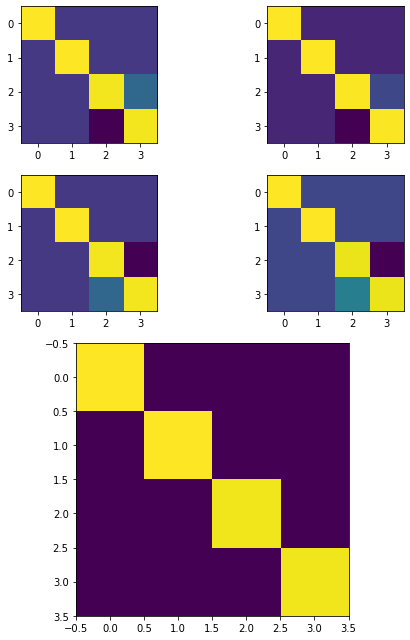

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sops = []

fig = plt.figure(figsize=(7, 9))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 2])

ax0 = fig.add_subplot(gs[0, 0])

ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 0])

ax3 = fig.add_subplot(gs[1, 1])

ax4 = fig.add_subplot(gs[2:, :])
axes = [ax0,ax1,ax2,ax3]


for i, scale in enumerate(scales):
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    #plt.subplot(subplots[i])
    axes[i].imshow(sop_to_ptm(error))
    sops.append(error)
    
avg = np.zeros((4,4))
for i, sop in enumerate(sops):
    avg += res[i] * sop_to_ptm(sop)
ax4.imshow(avg)
    # plt.show()
# plt.imshow(avg)
#plt.tight_layout()

plt.tight_layout()
plt.show()

In [38]:
[el for el in avg.flatten() if not np.isclose(0,el)]

[1.9999999999999887, 1.999999999999989, 1.9600616108078621, 1.9600616108078621]

In [12]:
print(avg)

[[ 2.00000000e+00  0.00000000e+00 -3.52004953e-17 -2.10303101e-17]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.39646399e-17  0.00000000e+00  1.96006161e+00  3.95017352e-13]
 [-2.10303101e-17  0.00000000e+00 -3.95017352e-13  1.96006161e+00]]


In [11]:
sop_to_ptm(error)

/Users/anthonypolloreno/.pyenv/versions/3.6.3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


array([[ 2.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.92405534, -0.54590387],
       [ 0.        ,  0.        ,  0.54590387,  1.92405534]])

/Users/anthonypolloreno/.pyenv/versions/3.6.3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


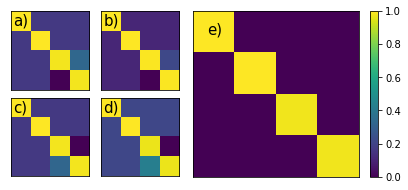

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
MAX = 1
sops = []
CMAP = 'viridis'

fig = plt.figure(figsize=(7,3.05), )
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1,1], width_ratios=[1,1,2.69])
gs.update(wspace=.1, hspace=.1)
ax0 = fig.add_subplot(gs[0, 0])

ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 0])

ax3 = fig.add_subplot(gs[1, 1])

ax4 = fig.add_subplot(gs[:, 2:])
axes = [ax0,ax1,ax2,ax3]


def normalize(mat):
    #RANGE = np.max(mat)-np.min(mat)
    mat -= np.min(mat)
    mat /= RANGE*MAX
    return mat

for i, scale in enumerate(scales):
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    #plt.subplot(subplots[i])
    ax = axes[i]
    mat = normalize(sop_to_ptm(error))
    ax.imshow(mat, cmap=CMAP)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    sops.append(error)
    
def get_axis_limits(ax):
    return ax.get_xlim()[0]+.12, (ax.get_ylim()[1]-ax.get_ylim()[0])*.82 + ax.get_ylim()[0]
ax0.annotate('a)', xy=get_axis_limits(ax0), c='k',size=15)
ax1.annotate('b)', xy=get_axis_limits(ax1), c='k',size=15)
ax2.annotate('c)', xy=get_axis_limits(ax2), c='k',size=15)
ax3.annotate('d)', xy=get_axis_limits(ax3), c='k',size=15)

ax4.annotate('e)', xy=(ax.get_xlim()[0]+.32, ax.get_ylim()[1]+.56), c='k',size=15)
avg = np.zeros((4,4))
for i, sop in enumerate(sops):
    avg += res[i]* sop_to_ptm(sop)
ax4.imshow(normalize(avg), cmap=CMAP)
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])
for PCM in ax.get_children():
    if type(PCM) == matplotlib.image.AxesImage: break
plt.colorbar(PCM,ax=ax4)
#plt.tight_layout()
plt.savefig("experimental-ptm.png", dpi=500)

Text(0.5, 1.0, 'gs[-1, -2]')

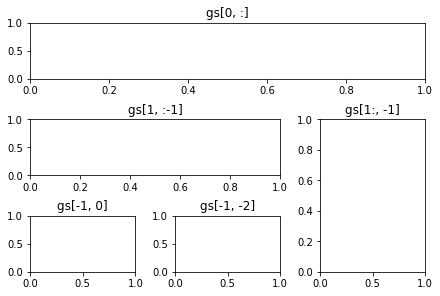

In [11]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[-1, 0])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[-1, -2])
f3_ax5.set_title('gs[-1, -2]')

IndexError: index 5 is out of bounds for axis 0 with size 2

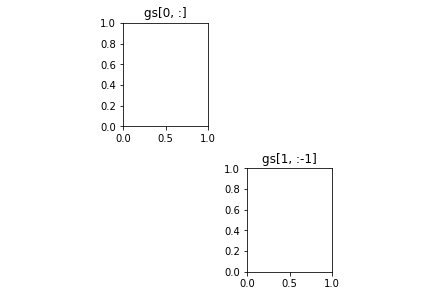

In [12]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(2,4)
f3_ax1 = fig3.add_subplot(gs[0, 1])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, 2])
f3_ax2.set_title('gs[1, :-1]')
#f3_ax3 = fig3.add_subplot(gs[2, 4] + gs[6, 8])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[5,6])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[6,7])
f3_ax5.set_title('gs[-1, -2]')